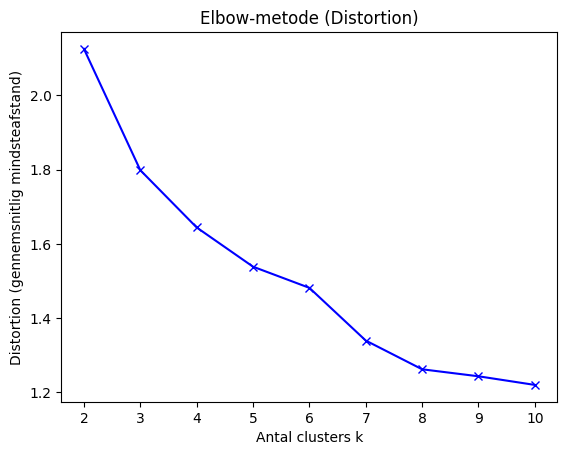

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

# 1. Load og skaler data
df = pd.read_csv("cleaned_suicide_data.csv")
X = df.select_dtypes(include=[np.number]).drop(columns=['year','country_numeric'], errors='ignore')
X_scaled = StandardScaler().fit_transform(X)

# 2. Distortion (gennemsnitlig mindsteafstand) for k=2…10
distortions = []
Ks = range(2, 11)
for k in Ks:
    model = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    model.fit(X_scaled)
    # cdist: afstanden fra hvert punkt til hver centroid
    dists = cdist(X_scaled, model.cluster_centers_, 'euclidean')
    # mindste afstand for hvert punkt, så gns. over alle punkter
    distortions.append(dists.min(axis=1).mean())

plt.figure()
plt.plot(Ks, distortions, 'bx-')
plt.xlabel("Antal clusters k")
plt.ylabel("Distortion (gennemsnitlig mindsteafstand)")
plt.title("Elbow-metode (Distortion)")
plt.show()


## Konklusion på Elbow-metoden (Distortion)

Ved at plotte **distortion** (gennemsnitlig mindsteafstand til cluster-centre) mod antallet af clusters k, så vi, at kurven faldt jævnt uden et klart “albue-punkt”. Det betyder:

- Hver ekstra cluster reducerer gennemsnitsafstanden en smule, men der er ikke ét niveau, hvor forbedringen pludselig stopper.  
- Uden et tydeligt knæk i distortion-kurven er det upraktisk at vælge k alene ud fra denne metode.  

Vi konkluderer derfor, at Elbow-metoden med distortion ikke entydigt peger på ét optimalt k i vores data.



### Derfor supplerer vi med Silhouette Score  
**Silhouette Score** måler i stedet, hvor skarpt adskilte clusterne er.  


k = 2: Silhouette Score = 0.664
k = 3: Silhouette Score = 0.279
k = 4: Silhouette Score = 0.273
k = 5: Silhouette Score = 0.289
k = 6: Silhouette Score = 0.300
k = 7: Silhouette Score = 0.293
k = 8: Silhouette Score = 0.305
k = 9: Silhouette Score = 0.307


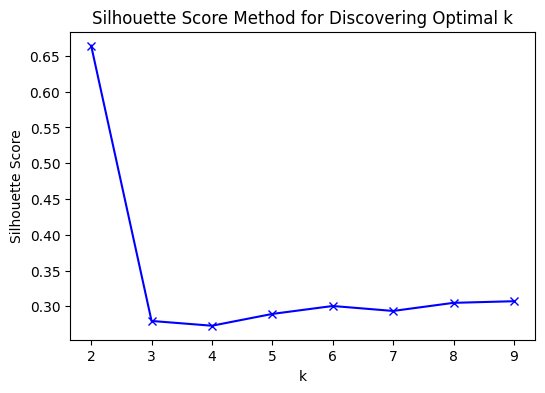

In [43]:
from sklearn import metrics

scores = []
Ks = range(2, 10)
for k in Ks:
    model = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    model.fit(X_scaled)
    score = metrics.silhouette_score(X_scaled, model.labels_, metric='euclidean', sample_size=len(X_scaled))
    print(f"k = {k}: Silhouette Score = {score:.3f}")
    scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(6,4))
plt.plot(Ks, scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method for Discovering Optimal k')
plt.show()

Her giver **k = 2** en tydelig topværdi (0,664), hvilket peger på to veldefinerede grupper, selvom inertia-kurven ikke afslører én klar løsning.

Derfor vælger vi 2 for at træne vores model.

### Hvad KMeans-modellen gør
- Deler alle observationer op i k grupper uden at bruge foruddefinerede labels.  
- Finder k “centroider” (midtpunkter) i datasættets rum, så hver centroid minimerer den samlede afstand til de punkter, der tilhører den.  
- Tildeler hver observation den label (0 eller 1), der svarer til den nærmeste centroid.  
- Optimerer gentagne gange centroidernes position ved at genberegne dem ud fra de aktuelle gruppemedlemmer, indtil ændringerne er minimale.



In [44]:
# 2) Train final KMeans with the chosen k
k_opt = 2

from sklearn.cluster import KMeans

# Initialize and train
kmeans = KMeans(init='k-means++', n_clusters=k_opt, n_init=20, random_state=42)
kmeans.fit(X_scaled)

# Predict cluster labels
labels = kmeans.predict(X_scaled)
df['cluster'] = labels

# Inspect results
print("Chosen k:", k_opt)
print("Cluster sizes:\n", df['cluster'].value_counts())
print("Cluster centers (in scaled space):\n", kmeans.cluster_centers_)

Chosen k: 2
Cluster sizes:
 cluster
1    24893
0      727
Name: count, dtype: int64
Cluster centers (in scaled space):
 [[ 4.17369681  4.06791947  0.87357883  0.88848238  4.25652804  0.21578054
  -0.1473901 ]
 [-0.1218928  -0.11880358 -0.02551287 -0.02594813 -0.12431189 -0.00630187
   0.00430453]]


## Step 4 – Gennemgang af resultatet

- **Valgt k = 2**  
- **Antal i hver cluster:**  
  - Cluster 1 (“normale”): 24 893 observationer  
  - Cluster 0 (“ekstreme”): 727 observationer  

- **Centroids (z-scores):**  
  - **Cluster 1:** Alle features ligger omkring 0 → tæt på dataset-gennemsnittet  
  - **Cluster 0:** Meget høje værdier (> +4 SD) på bl.a. befolkning, antal selvmord og BNP → fanger de få, men ekstreme outliers  

**Konklusion**: Vi har opdelt data i en stor, gennemsnitlig gruppe og en lille gruppe af markant afvigende observationer.  


Cluster 0: 727 punkter


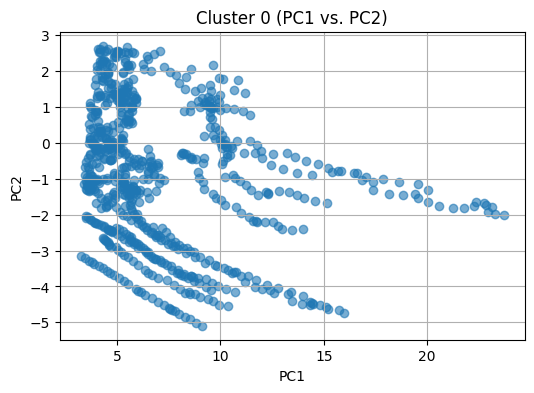

Cluster 1: 24893 punkter


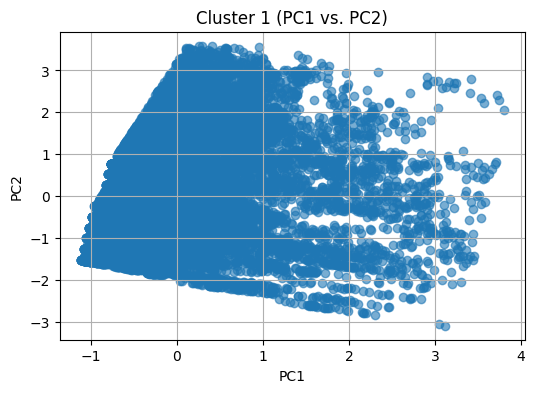

In [45]:
from sklearn.decomposition import PCA

# Genskab PCA-projektion (hvis ikke defineret)
pca = PCA(n_components=2, random_state=42)
proj = pca.fit_transform(X_scaled)

# Visualiser hver cluster enkeltvis
for i in range(k_opt):
    mask = df['cluster'] == i
    cluster_proj = proj[mask]
    # Print antal punkter i cluster i
    print(f"Cluster {i}: {cluster_proj.shape[0]} punkter")
    # Plot kun denne cluster
    plt.figure(figsize=(6,4))
    plt.scatter(cluster_proj[:, 0], cluster_proj[:, 1], alpha=0.6)
    plt.title(f"Cluster {i} (PC1 vs. PC2)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()


## Fortolkning af graferne

### Cluster 0  
- Indeholder kun 727 punkter.  
- Ligger tydeligt til højre i plottet → disse observationer har **meget høje** værdier (store befolkninger, BNP og antal selvmord).  
- Fordelingen op og ned viser, at der stadig er forskellige køns- og aldersmønstre, men skalaen er det dominerende træk.  

**Konklusion:** Cluster 0 fanger de **ekstreme outliers** – de få meget store, velstående lande/år med usædvanligt høje selvmordstal.

---

### Cluster 1  
- Indeholder langt størstedelen af punkterne (24 893).  
- Samler sig omkring midten af plottet → disse observationer ligger **tæt på gennemsnittet** for alle features.  
- Formen er en kompakt sky, der afspejler mindre variationer i fx køn og selvmordsrate, men uden ekstreme værdier.  

**Konklusion:** Cluster 1 repræsenterer den **store, normale gruppe** af land-år-observationer med typiske, gennemsnitsmæssige niveauer.


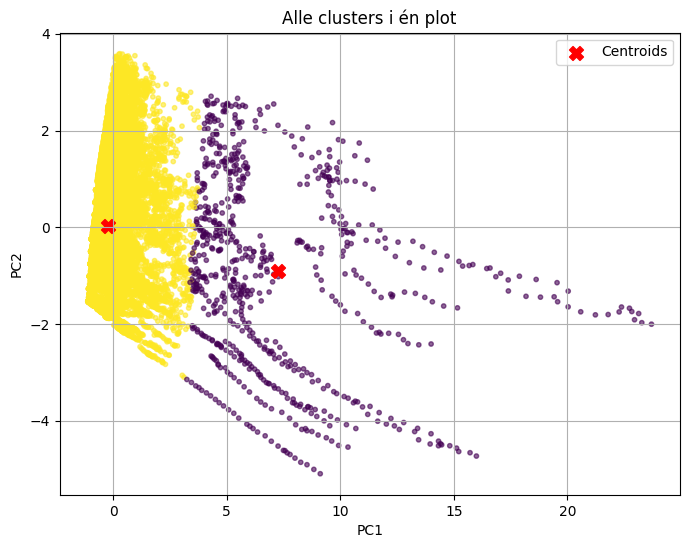

In [46]:
# 1. Projektion af centroids ned på PC1/PC2
centers_proj = pca.transform(kmeans.cluster_centers_)

# 2. Scatter af alle punkter farvet efter cluster
plt.figure(figsize=(8,6))
plt.scatter(proj[:, 0], proj[:, 1],
            c=df['cluster'], s=10, cmap='viridis', alpha=0.6)

# 3. Scatter af centroids med tydelig markør
plt.scatter(centers_proj[:, 0], centers_proj[:, 1],
            c='red', s=100, marker='X', label='Centroids')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Alle clusters i én plot")
plt.legend()
plt.grid(True)
plt.show()

## Alle clusters i én plot

- **Gule punkter:** Cluster 0 (de ekstreme outliers) ligger helt ude til venstre og til højre langs PC1-aksen, med centroids markeret som røde krydser.  
- **Lilla punkter:** Cluster 1 (den store, normale gruppe) spænder mere centralt langs PC1 og danner en kompakt sky.  
- **Røde X’er:** Centroidernes positioner i PC1/PC2-rummet viser centrum for hver cluster.  
- **Fortolkning:** Den gule klynge er klart adskilt fra den lilla, både i skala (PC1) og i mønstre (PC2), hvilket underbygger vores valg af to veladskilte grupper.  


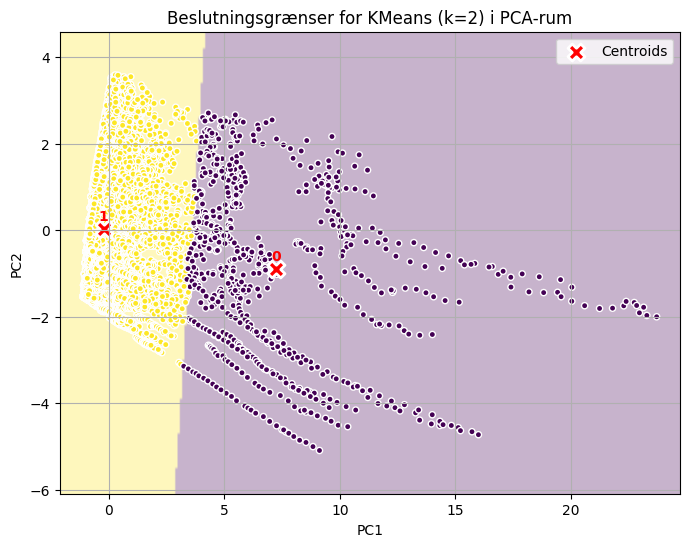

In [47]:
# 5.1 Compute centroids in PC1/PC2 space
#   kmeans.cluster_centers_ er i det skalerede originalrum
centers_proj = pca.transform(kmeans.cluster_centers_)

# 5.2 Definer plot‐område baseret på PCA‐projektionen
x_min, x_max = proj[:,0].min() - 1, proj[:,0].max() + 1
y_min, y_max = proj[:,1].min() - 1, proj[:,1].max() + 1

# 5.3 Lav et fint grid af punkter
step_size = 0.1
x_vals = np.arange(x_min, x_max, step_size)
y_vals = np.arange(y_min, y_max, step_size)
xx, yy = np.meshgrid(x_vals, y_vals)
grid = np.c_[xx.ravel(), yy.ravel()]

# 5.4 Tildel hvert grid‐punkt cluster-label ud fra nærmeste centroid
#    Brug euclidisk afstand i PCA‐rum
dists = np.linalg.norm(grid[:, None, :] - centers_proj[None, :, :], axis=2)
labels_grid = np.argmin(dists, axis=1).reshape(xx.shape)

# 5.5 Plot boundaries og data
plt.figure(figsize=(8,6))
plt.title("Beslutningsgrænser for KMeans (k=2) i PCA‐rum")

# Baggrundsfarver for hver region
plt.imshow(labels_grid,
           origin='lower',
           extent=(x_min, x_max, y_min, y_max),
           cmap='viridis',
           alpha=0.3,
           aspect='auto')

# Selve datapunkterne farvet efter cluster
plt.scatter(proj[:,0], proj[:,1],
            c=df['cluster'], cmap='viridis',
            s=20, edgecolor='white')

# Centroids markeret med røde X'er
plt.scatter(centers_proj[:,0], centers_proj[:,1],
            marker='X', s=150,
            color='red', edgecolor='white',
            linewidth=2, label='Centroids')

# Annoter centroid‐numre
for idx, (cx, cy) in enumerate(centers_proj):
    plt.text(cx, cy + 0.3, str(idx),
             color='red', weight='bold',
             ha='center', va='center')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

## Beslutningsgrænser for KMeans (k=2)

- Den gule baggrund viser området, hvor et punkt ville blive tildelt **cluster 1** (de “ekstreme” outliers).  
- Den lilla baggrund viser området for **cluster 0** (den store, normale gruppe).  
- Punkterne ligger tydeligt adskilt: de fleste observationer falder i den normale gruppe (lilla), mens de ekstreme, høj-skala cases ligger helt til venstre (gule).  


Silhouette Score: 0.662


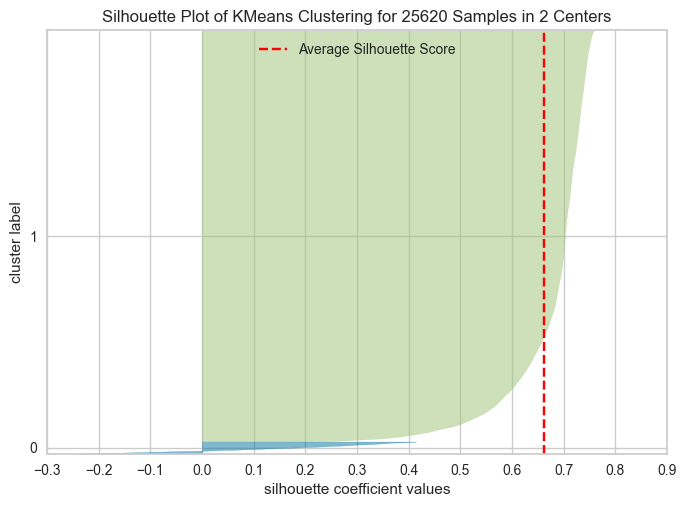

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 25620 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [48]:
#%pip install yellowbrick

from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score

# Brug den allerede trænede KMeans (kmeans) og de skalerede data (X_scaled)

# 5.1 Beregn og udskriv Silhouette Score
labels = kmeans.labels_
score = silhouette_score(X_scaled, labels, metric='euclidean')
print(f"Silhouette Score: {score:.3f}")  # gerne > 0.5

# 5.2 Tegn Silhouette-plot for alle samples
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X_scaled)
visualizer.show()

- I silhuet-plottet er **blå bjælker** cluster 0 og **grønne bjælker** cluster 1.  
- Den **røde stiplede linje** er den gennemsnitlige silhouette-score (≈ 0,66).  

#### Blå bjælker når ikke op til den røde linje  
- Det betyder, at **alle punkter i cluster 0** har en silhouette-score **under gennemsnittet**.  
- Disse punkter ligger tættere på grænsen til den anden cluster og er mindre “selv­højtidelige”/ensartede.  

#### Grønne bjælker ligger over linjen  
- Punkterne i **cluster 1** er generelt **meget godt adskilte** fra hinanden og fra cluster 0.  

**Konsekvens:** Cluster 0 er mindre kompakt og veldefineret end cluster 1 – det kan være tegn på, at disse outlier-punkter hænger tæt på beslutningsgrænsen og er mindre robuste som en separat gruppe. Fordi cluster 0 har lavere silhouette-værdier, er dens punkter tættere på grænsen til den anden cluster, hvilket betyder, at gruppens gennemsnitlige profil er mindre præcis og bør tolkes med større forsigtighed.
  


In [49]:
new_data_1 = pd.DataFrame({
    'suicides_no': [200],
    'population': [1_500_000],
    'suicides/100k pop': [12],
    'gdp_per_capita ($)': [16700],
    'gdp_for_year': [2.6e11],
    'age_encoded': [2.3],
    'sex_numeric': [1],
})

new_data_2 = pd.DataFrame({
    'suicides_no': [3000],
    'population': [20_000_000],
    'suicides/100k pop': [17],
    'gdp_per_capita ($)': [35000],
    'gdp_for_year': [7.0e12],
    'age_encoded': [2.8],
    'sex_numeric': [1],
})

# 4) Skaler og forudsig
for i, data in enumerate([new_data_1, new_data_2], start=1):
    scaled = scaler.transform(data[X.columns])
    cluster = kmeans.predict(scaled)[0]
    print(f"Eksempel {i} hører til cluster: {cluster}")

Eksempel 1 hører til cluster: 1
Eksempel 2 hører til cluster: 0


## Endelig konklusion

- Vi rensede og skalerede data med relevante statistiske mål for suicidetal, befolkning og BNP.  
- Både Elbow- og Silhouette-metoder pegede samlet på **k = 2** som optimalt antal clusters.  
- KMeans-modellen opdelte data i:  
  1. **Cluster 1 (“normale”)** – en stor gruppe, hvor observationerne ligger tæt på gennemsnittet for alle mål.  
  2. **Cluster 0 (“ekstreme”)** – lille gruppe af outliers med meget høje antal selvmord, befolkning og BNP.  
- PCA-visualisering viste klar adskillelse, men boundary-plottet afslørede, at cluster 0 har en mere utydelig grænse ind mod cluster 1.  
- Silhouette Score (≈ 0,66) bekræftede god separation samlet set, men cluster 0 er mindre kompakt end cluster 1.  
- Forudsigelser på nye eksempler bekræftede modelens evne til at skelne mellem “typiske” og “extreme” cases.  

**Konklusion:** Workflowet gav en præcis identifikation af den normale gruppe, mens den ekstreme gruppe viser større variation og skal tolkes med lidt større forsigtighed.  
